# Image Classification RNN

Neste notebook veremos como podemos utilizar uma [recurrent neural network (RNN)](https://en.wikipedia.org/wiki/Recurrent_neural_network) na classificação de imagens.

Para este experimento, vamos usar o conjunto de dados de dígitos MNIST.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

Carregamos os conjuntos de treinamento e teste:

In [2]:
train_dataset = torchvision.datasets.MNIST(
    root = '.',
    train = True,
    transform = transforms.ToTensor(),
    download = True
)

test_dataset = torchvision.datasets.MNIST(
    root = '.',
    train = False,
    transform = transforms.ToTensor(),
    download = True
)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Definimos os **DataLoaders**:

In [3]:
batch_size = 128

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Construímos o Modelo de Classificação:

In [4]:
class RNN(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
        super(RNN, self).__init__()
        self.D = n_inputs
        self.M = n_hidden
        self.K = n_outputs
        self.L = n_rnnlayers

        self.rnn = nn.LSTM(
            input_size=self.D,
            hidden_size=self.M,
            num_layers=self.L,
            batch_first=True)
        self.fc =nn.Linear(self.M, self.K)

    def forward(self, X):
        # initial hidden states
        h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        c0 = torch.zeros(self.L, X.size(0), self.M).to(device)

        # get RNN unit output
        out, _ = self.rnn(X, (h0, c0))

        # we only want h(T) at the final time step
        out = self.fc(out[:, -1, :])
        return out

Instanciamos o modelo:

In [5]:
model = RNN(28, 128, 2, 10)

Ajustamos o modelo ao dispositivo de processamento:

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda:0


RNN(
  (rnn): LSTM(28, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=10, bias=True)
)

Definimos a função Loss e o Optimizer:

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

Treinamos o modelo:

In [8]:
n_epochs = 10
train_losses = np.zeros(n_epochs)
test_losses = np.zeros(n_epochs)

for it in range(n_epochs):
    train_loss = []
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        inputs = inputs.view(-1, 28, 28)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
    train_loss = np.mean(train_loss) 

    test_loss = []
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        inputs = inputs.view(-1, 28, 28)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss.append(loss.item())
    test_loss = np.mean(test_loss)

    train_losses[it] = train_loss
    test_losses[it] = test_loss

    print(f'Epoch {it+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

Epoch 1/10, Train Loss: 0.5682, Test Loss: 0.1489
Epoch 2/10, Train Loss: 0.1305, Test Loss: 0.1061
Epoch 3/10, Train Loss: 0.0881, Test Loss: 0.0767
Epoch 4/10, Train Loss: 0.0642, Test Loss: 0.0631
Epoch 5/10, Train Loss: 0.0538, Test Loss: 0.0552
Epoch 6/10, Train Loss: 0.0444, Test Loss: 0.0457
Epoch 7/10, Train Loss: 0.0360, Test Loss: 0.0472
Epoch 8/10, Train Loss: 0.0342, Test Loss: 0.0437
Epoch 9/10, Train Loss: 0.0295, Test Loss: 0.0437
Epoch 10/10, Train Loss: 0.0268, Test Loss: 0.0439


Plotamos a loss de treinamento e teste por iteração:

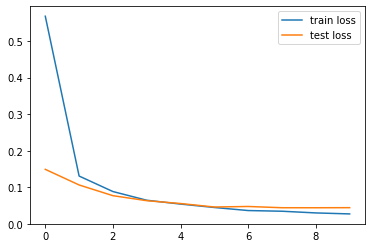

In [9]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend();

Calculamos a **Accuracy** do modelo:

In [10]:
n_correct = 0.
n_total = 0.
for inputs, targets in train_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    inputs = inputs.view(-1, 28, 28)
    outputs = model(inputs)
    _, predictions = torch.max(outputs, 1)
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

train_acc = n_correct / n_total

n_correct = 0.
n_total = 0.
for inputs, targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    inputs = inputs.view(-1, 28, 28)
    outputs = model(inputs)
    _, predictions = torch.max(outputs, 1)
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

test_acc = n_correct / n_total
print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.9938, Test acc: 0.9884


Criamos uma função cuja responsabilidade é plotar a matriz de confusão:

In [11]:
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Obtemos todas as previsões em um array e plotamos a matriz de confusão:

Confusion matrix, without normalization
[[ 972    0    1    1    0    0    4    1    0    1]
 [   0 1131    1    2    0    0    1    0    0    0]
 [   0    1 1026    3    0    0    1    0    1    0]
 [   0    0    3 1004    0    2    0    0    1    0]
 [   0    1    2    0  968    0    5    3    1    2]
 [   1    0    2    6    0  880    1    0    2    0]
 [   2    2    1    0    1    3  949    0    0    0]
 [   0    3    7    2    2    1    0 1007    2    4]
 [   0    0    1    3    1    4    0    1  962    2]
 [   0    1    0    2   11    2    1    3    4  985]]


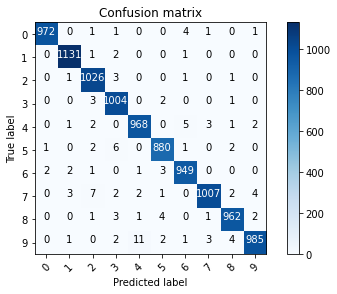

In [12]:
x_test = test_dataset.data.numpy()
y_test = test_dataset.targets.numpy()
p_test = np.array([])

for inputs, targets in test_loader:
  inputs, targets = inputs.to(device), targets.to(device)
  inputs = inputs.view(-1, 28, 28)
  outputs = model(inputs)
  _, predictions = torch.max(outputs, 1)
  p_test = np.concatenate((p_test, predictions.cpu().numpy()))

cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))

Por fim, apresentamos exemplos que foram classificados incorretamente:

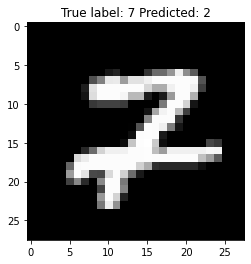

In [13]:
misclassified_idx = np.where(p_test != y_test)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(x_test[i], cmap='gray')
plt.title("True label: %s Predicted: %s" % (y_test[i], int(p_test[i])));